# Use case wildfires: Application FWI



## Canadian Forest Fire Weather Index (FWI)

#### –meteorological conditions, potential fire danger

#### Fire weather: conditions conducive to the occurrence and sustaining of fires - compound of hot, dry and windy weather

#### FWI represents potential fire danger rather than actual fire occurrence

#### FWI account for significant drivers of fire weather (temperature, precipitation, relative humidity, and wind speed). 

#### Studies have found significant relationships between the FWI and the burned area, making index relevant for impact assessments.

#### Readily available input variables make FWI highly portable to be used at regional/global scale for fire danger prediction and warning systems, or fire danger projections under climate change.


## Structure of the FWI System

#### Step1: The moisture contents of organic materials: Fine Fuel Moisture Code (FFMC), the Duff Moisture Code (DMC) and the Drought Code (DC). 

The FFMC rates the moisture content of fine fuels and of the litter, hence the probability of ignition. 

The DMC rates the moisture content of slightly compacted organic layers at medium depth, giving a sense of the fuel consumption. 

The DC rates the moisture content of deep and compact organic layers, depicting the behaviour of slow burning materials and representing seasonal effects. 

#### Step2: Two indices are deduced from these moisture contents. The Initial Spread Index (ISI) is an indicator for the likely rate of fire spread, while the Buildup Index (BUI) encompasses the fuel available for combustion

#### Step3: Together, they are used to deduce the FWI rating the fire intensity.




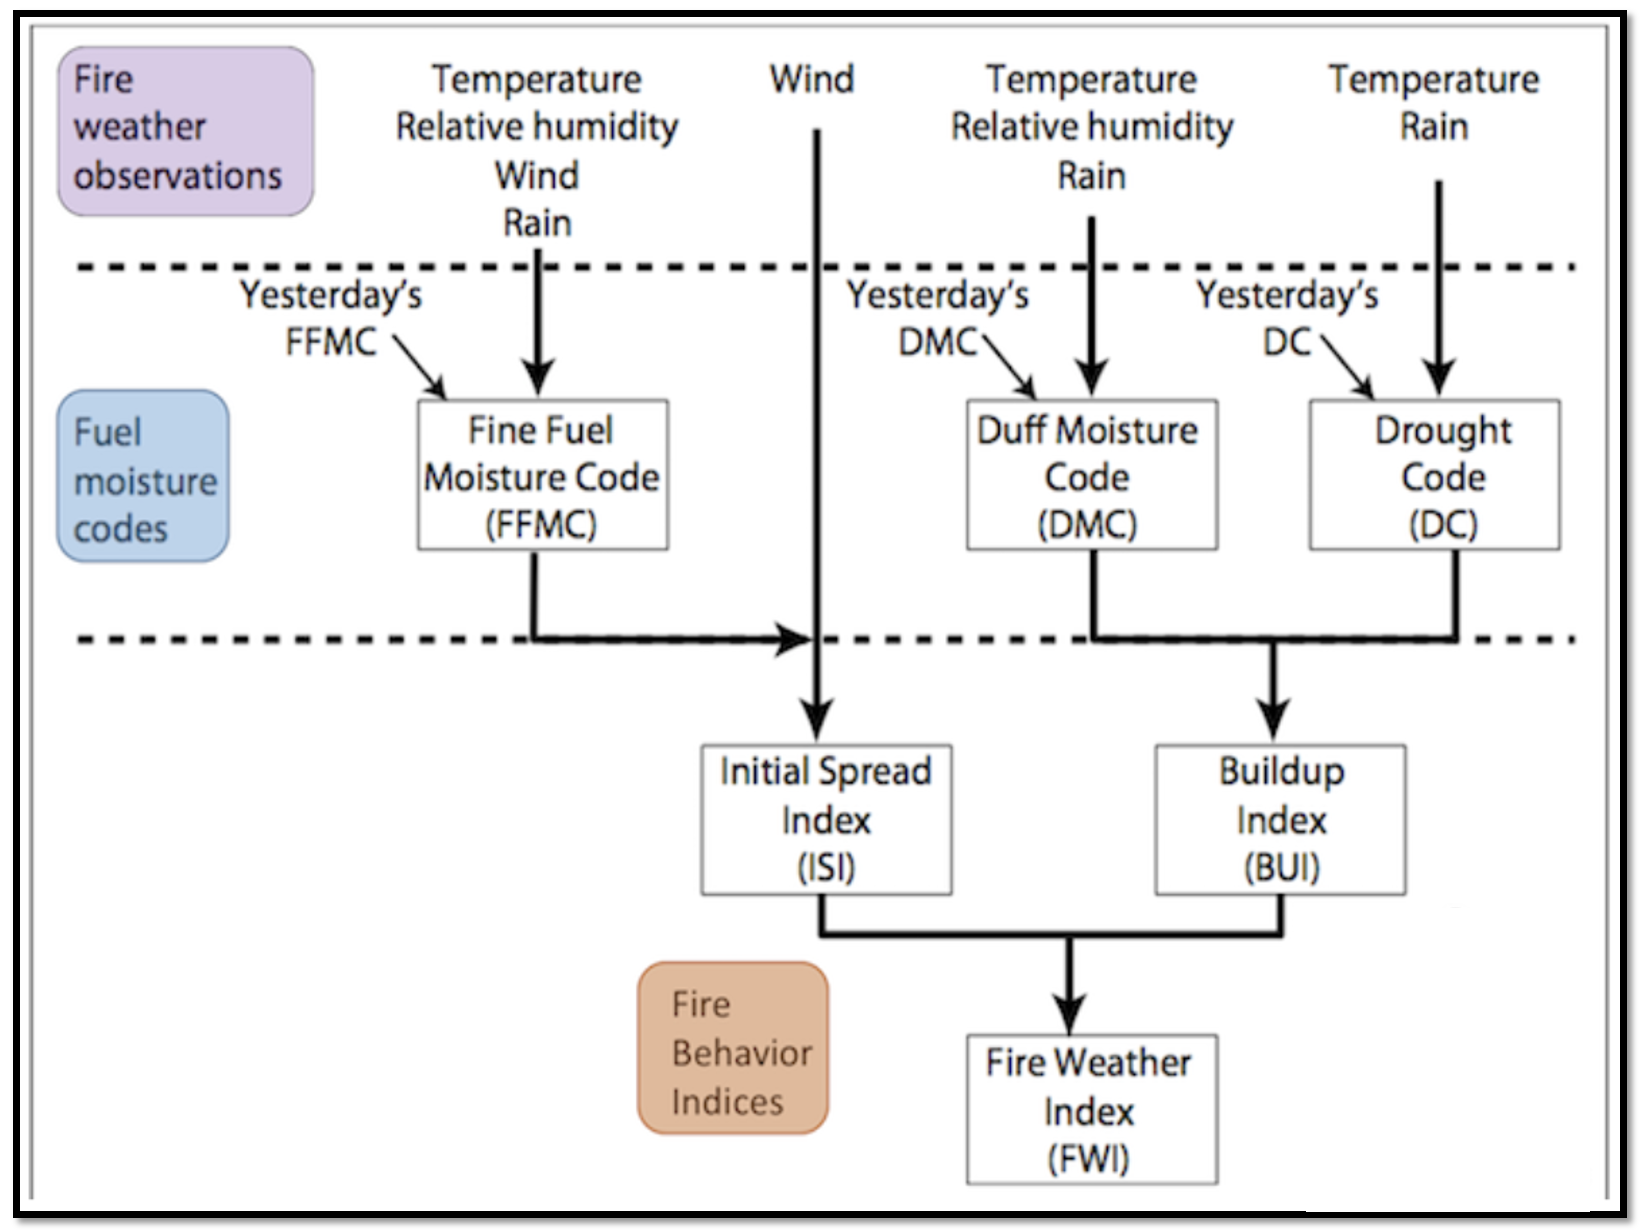




## Fire Danger Classes
#### The European Forrest Fire Information System classifications of fire danger 

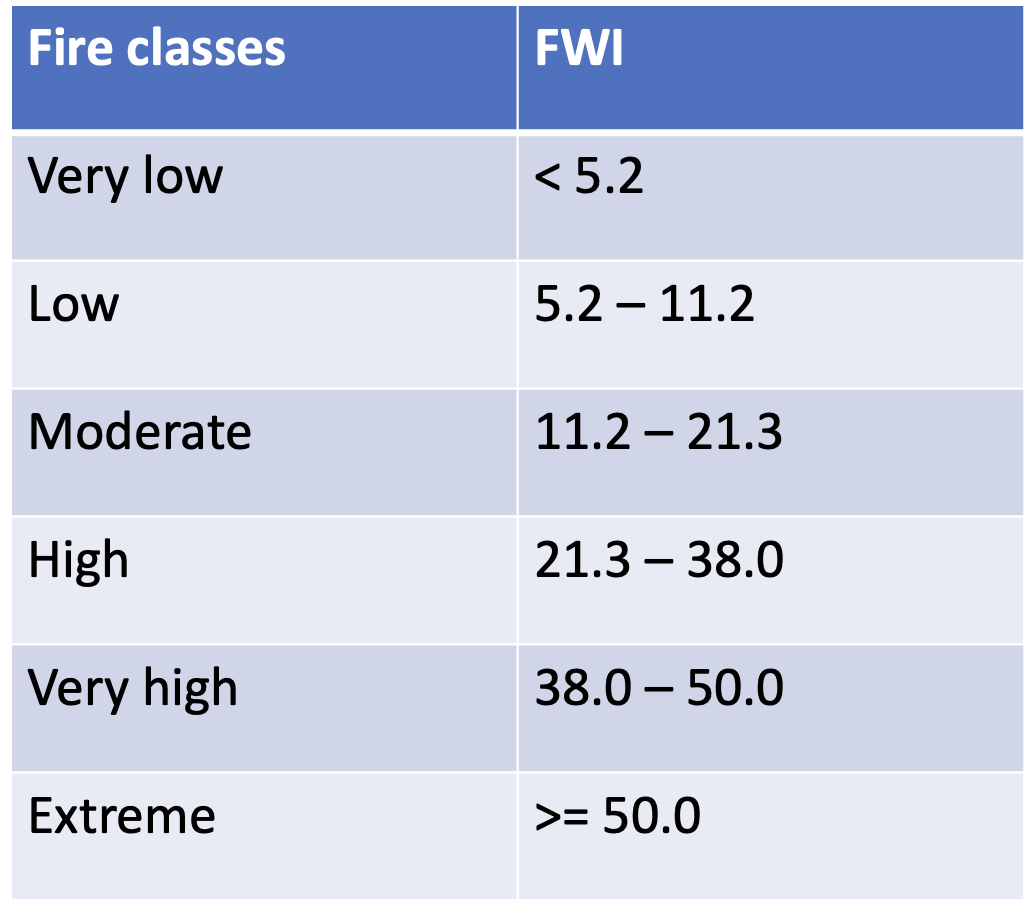

## Modification of the FWI to be applicable for Europe

#### FWI is developed for Canadian boreal temperate forests. 
**Issues**: Climate-DT application of FWI to different climate and vegetation environments: Europe 

**Update 1: day length**

**Issue:** Fixed day length as a function of the month (at 70N)

**Solution:** Dynamical day length calculation as a function of latitude and month



**Update 2: drying factor** 

**Issue:** Fixed values 

**Solution:** Value depending on the hemisphere 



**Update 3: Overwintering** 

**Issue:** The moisture content of deep organic layers is almost saturated in spring, even over the regions with dry winters.

**Solution:** Use a value of DC at the end of the fire season and the precipitation up to the start of the fire season



**Update 4: Onset and end of the fire season**

**Issue:** User-defined subjective onset and end date

**Solution:**
Onset: Temperature > 12 °C  for the three consecutive days 
End: Temperature < 5 °C for the three consecutive days 


## Expected main results
#### Changes in fire danger and fire season in Europe under different scenarios

#### Identification of extreme fire weather events

#### Spatial and temporal distribution of fire danger in Europe

## CODE

The FWI application has been developed based on the detailed descriptions provided by Van Wagner in 1987 and the Fortran-based code provided by Van Wagner and Pickett in 1985. 


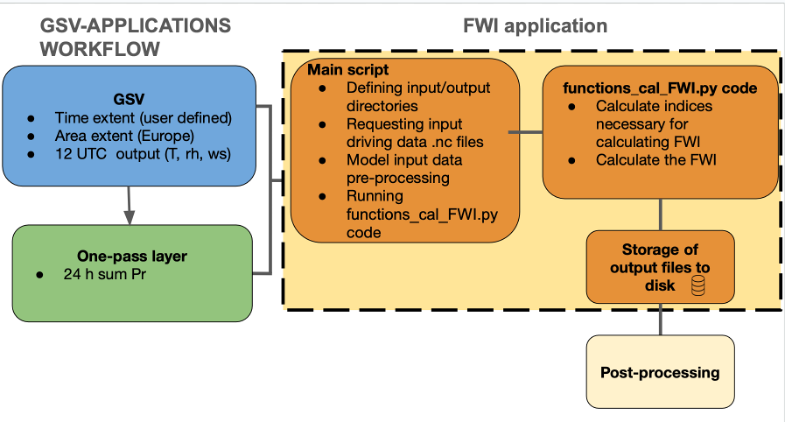

## Input variables:

### 1. Temperature, relative humidity, and wind speed at 12 UTC
### 2. Last 24-hour precipitation sum average over before 12 UTC

# run_wildfire_FWI.py


In [ ]:
import os
import sys  # used for running all at once
import time
import numpy as np
import xarray as xr
import pandas as pd
import argparse

from functions_cal_FWI import *


# First step, create a parser:
parser = argparse.ArgumentParser(description="Runscript for the wildfires_fwi application")


# Second step, add positional arguments or
# https://docs.python.org/3/library/argparse.html#argparse.ArgumentParser.add_argument
parser.add_argument('-year', required=True, help="Input year for the wildfires_fwi app", default=1)
parser.add_argument('-month', required=True, help="Input month for the wildfires_fwi app", default=2)
parser.add_argument('-day', required=True, help="Input day for the wildfires_fwi app", default=3)
parser.add_argument('-hpctmpdir', required=True, help="Input expid for the wildfires_fwi app", default=4)

# Third step, parse arguments.
# The default args list is taken from sys.args
args = parser.parse_args()

year = args.year
month = args.month
day = args.day
hpctmpdir = args.hpctmpdir


# Provide the input and output DIR path
in_path  = f'{hpcrootdir}/'
out_path = f'{hpcrootdir}/'
ct_path  = f'{hpcrootdir}/'

# Provide the data file name for all variables 
temp_name   = f'{year}_{month}_{day}_T00_00_to_{year}_{month}_{day}_T23_00_2t_raw_data.nc' #2m_temperature_DMIN_era5Land.nc"
pr_name     = f'{year}_{month}_{day}_T13_tp_daily_noon_sum.nc' #total_precipitation_DSUM_era5Land.nc"
uwind_name  = f'{year}_{month}_{day}_T00_00_to_{year}_{month}_{day}_T23_00_10u_raw_data.nc'#"10m_u_component_of_wind_DMIN_era5Land.nc"
vwind_name  = f'{year}_{month}_{day}_T00_00_to_{year}_{month}_{day}_T23_00_10v_raw_data.nc' #"10m_v_component_of_wind_DMIN_era5Land.nc"
d2m_name    = f'{year}_{month}_{day}_T00_00_to_{year}_{month}_{day}_T23_00_2d_raw_data.nc'#"2m_dewpoint_temperature_DMIN_era5Land.nc"
out_name    = f'fwi_output_{year}{month}{day}.nc'
ct_name     = f"FWI_Const1.nc"


file_t2m   = os.path.join(in_path, temp_name)
file_pr    = os.path.join(in_path, pr_name)
file_d2m   = os.path.join(in_path, d2m_name)
file_10u   = os.path.join(in_path, uwind_name)
file_10v   = os.path.join(in_path, vwind_name)
out_file   = os.path.join(in_path, out_name)
const_file = os.path.join(in_path, ct_name)

# Read data
ds_pr      = xr.open_dataset(file_pr)
ds_d2m     = xr.open_dataset(file_d2m)
ds_10u     = xr.open_dataset(file_10u)
ds_10v     = xr.open_dataset(file_10v)
ds_t2m     = xr.open_dataset(file_t2m)


wspd = np.sqrt((ds_10u['10u'] * ds_10u['10u']) + (ds_10v['10v'] * ds_10v['10v']))
del  ds_10u, ds_10v, ds_10u,ds_10v 

# Access temperature and dew point temperature variables
tas = ds_t2m['2t']  # Current temperature (in Kelvin)
dev = ds_d2m['2d']  # Dew point temperature (in Kelvin)


# Convert nuit m to mm
ds_pr['tp'] = ds_pr['tp']* 1000
pr          = ds_pr['tp']

# Calculate saturation vapor pressure from dew point temperature
sat_dew = 6.11 * np.exp(53.49 - 6808 / dev - 5.09 * np.log(dev))

# Calculate saturation vapor pressure from current temperature
sat_tas = 6.11 * np.exp(53.49 - 6808 / tas - 5.09 * np.log(tas))

# Calculate relative humidity
rhum = (sat_dew / sat_tas) * 100
 
#Correct the units 

#Temperature K == Deg C
tas = tas - 273.15

#"Wind speed m/s == km/h
wspd = wspd * 3.6

rhum = xr.where(rhum > 100, 100, rhum)


FWI_all = xr.full_like(tas, 0.0)


numb_day = sum([pd.Period(f'{year}-{i}-1').daysinmonth for i in range(1,13)])
numb_day_aligned = xr.full_like(tas.isel(time=0), numb_day)

MONTH_in = tas.time.dt.month
MONTH_aligned = MONTH_in.broadcast_like(tas)

LAT_in    = tas.lat
LAT_aligned = LAT_in.broadcast_like(tas)


# Define conf variables
# Which variables are used: 'hurs-tas'
type_variables = "hurs-tas"

# Which type of drying factor: 'original', 'NSH', 'NSHeq'
adjust_DryingFactor = "NSHeq"

# Which type of DayLength: 'original', 'bins', 'continuous'
adjust_DayLength = "continuous"

# Adjustment with overwintering DC: 'original', 'wDC'
adjust_overwinterDC = "original"


class Config:
	def __init__(self, type_variables, adjust_DryingFactor, adjust_DayLength, adjust_overwinterDC):
		self.type_variables = type_variables
		self.adjust_DryingFactor = adjust_DryingFactor
		self.adjust_DayLength = adjust_DayLength
		self.adjust_overwinterDC = adjust_overwinterDC
			
# Create an instance of the Config class with the desired values
cfg = Config("hursmin-tasmax", "NSHeq", "continuous", "original")
	
	
	
for i in range(len(tas.time)):
	#First initialize FFMC, DMC, and DC
	tas_slice = tas.isel(time=i)
	rhum_slice = rhum.isel(time=i)
	wspd_slice = wspd.isel(time=i)
	pr_slice = pr.isel(time=i)
	lat_slice = LAT_aligned.isel(time=i)
	month_slice = MONTH_aligned.isel(time=i)
	
	if int(tas_slice.time.dt.month) == 1 and int(tas_slice.time.dt.day) ==1:
		FFMCPrev = xr.full_like(tas.isel(time=0), 0.00001)
		DMCPrev = xr.full_like(tas.isel(time=0), 0.00001)
		DCPrev = xr.full_like(tas.isel(time=0), 0.00001)
		dataset = xr.Dataset({
		'FFMCPrev': FFMCPrev,
		'DMCPrev': DMCPrev,
		'DCPrev': DCPrev})
		dataset.to_netcdf(const_file)			
	else:
		ds_con      = xr.open_dataset(const_file)
		FFMCPrev = ds_con.FFMCPrev
		DMCPrev = ds_con.DMCPrev
		DCPrev = ds_con.DCPrev
		os.remove(const_file)
		    	
	FFMCPrev_in = FFMCPrev.values
	DMCPrev_in  = DMCPrev.values
	DCPrev_in   = DCPrev.values	  
	  
# Step1
	FFMC_in = FFMC(tas_slice.values, rhum_slice.values, wspd_slice.values, pr_slice.values, FFMCPrev_in)      
	DMC_in  = DMC(tas_slice.values, rhum_slice.values, pr_slice.values, DMCPrev_in, lat_slice.values, numb_day_aligned.values, month_slice.values, cfg) 
	DC_in   = DC(tas_slice.values, pr_slice.values, DCPrev_in, lat_slice.values, month_slice.values, cfg) 
# Step2    
	ISI_in  = ISI(wspd_slice.values, FFMC_in)
	BUI_in  = BUI(DMC_in, DC_in)
# Step3    
	FWI_in  = FWI(ISI_in, BUI_in)
	FWI_all[i,:,:] = FWI_in
		
		
	FFMC_in_xr = xr.DataArray(FFMC_in, coords={'lat': tas.lat, 'lon': tas.lon}, dims=['lat', 'lon'])
	DMC_in_xr  = xr.DataArray(DMC_in, coords={'lat': tas.lat, 'lon': tas.lon}, dims=['lat', 'lon'])
	DC_in_xr   = xr.DataArray(DC_in, coords={'lat': tas.lat, 'lon': tas.lon}, dims=['lat', 'lon'])
	
	dataset    = xr.Dataset({
		'FFMCPrev': FFMC_in_xr,
		'DMCPrev': DMC_in_xr,
		'DCPrev': DC_in_xr})
	dataset.to_netcdf(const_file)
	dataset.close()
			
	del FFMC_in, DMC_in, DC_in, ISI_in, BUI_in, FWI_in  
		
FWI_all.attrs = {'long_name': 'Fire Weather Index', 'units': 'unit'}
FWI_all = FWI_all.to_dataset(name='fwi')

FWI_all .to_netcdf(path=out_file)	

print("Finished!")


checkOutputFile = f'{hpctmpdir}/fwi_output_{year}{month}{day}.nc'


if os.path.exists(checkOutputFile):
    print('Output for wildfires_fwi application has been generated!')
    print('Inspect output for validity.')
else:
    print('Output for wildfires_fwi application has NOT been generated!')

# =====================================================================


# Post-processing 

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import os
import numpy as np
np.warnings = warnings
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd  
import datetime as dt

/Users/poladesu/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


##  Provide the data path

In [3]:
dat_path  = '/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ERA5_FWI_Data/'
dat_path1 = '/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/'
plot_dir  = '/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/'

## Read data and calculate the statistics


In [4]:
# Read the FWI index
file_in   = dat_path + "FWI_ClimateDt_*.nc"
ds        = xr.open_mfdataset(file_in)

In [5]:
# Read the land sea mask
#ds_lsm = xr.open_dataset(dat_path1 + "ERA5_LandSea_mask.nc")
ds_lsm = xr.open_dataset(dat_path1 + "ERA5_LandSea_mask_Proj.nc")

# Extract land mask
land_mask = ds_lsm.lsm > 0.5  # 1 represents land, 0 represents ocean

land_mask = land_mask.rename({'longitude': 'lon','latitude': 'lat'})
    


In [6]:
# Calculate the number of days exceeding different thresholds
ds.time

fwi_Vlow = (ds.fwi < 5.2).groupby('time.year').sum('time')
fwi_climatology_Vlow = fwi_Vlow.sel(year=slice('1991','2000')).mean(dim='year')
fwi_climatology_Vlow = fwi_climatology_Vlow.where(fwi_climatology_Vlow > 0, np.nan)
fwi_climatology_Vlow.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_VLow.nc')

fwi_low = ((ds.fwi > 5.2) & (ds.fwi < 11.2)).groupby('time.year').sum('time')#fwi_climatology_low = fwi_low.mean(dim='year')
fwi_climatology_low = fwi_low.sel(year=slice('1991','2000')).mean(dim='year')
fwi_climatology_low = fwi_climatology_low.where(fwi_climatology_low > 0, np.nan)
fwi_climatology_low.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_Low.nc')

fwi_mod = ((ds.fwi > 11.2) & (ds.fwi < 21.3)).groupby('time.year').sum('time')#fwi_climatology_low = fwi_low.mean(dim='year')
fwi_climatology_mod = fwi_mod.sel(year=slice('1991','2000')).mean(dim='year')
fwi_climatology_mod = fwi_climatology_mod.where(fwi_climatology_mod > 0, np.nan)
fwi_climatology_mod.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_Mod.nc')

fwi_high = ((ds.fwi > 21.3) & (ds.fwi < 38.0)).groupby('time.year').sum('time')#fwi_climatology_low = fwi_low.mean(dim='year')
fwi_climatology_high = fwi_high.sel(year=slice('1991','2000')).mean(dim='year')
fwi_climatology_high = fwi_climatology_high.where(fwi_climatology_high > 0, np.nan)
fwi_climatology_high.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_High.nc')

fwi_Vhigh = ((ds.fwi > 38.0) & (ds.fwi < 50)).groupby('time.year').sum('time')#fwi_climatology_low = fwi_low.mean(dim='year')
fwi_climatology_Vhigh = fwi_Vhigh.sel(year=slice('1991','2000')).mean(dim='year')
fwi_climatology_Vhigh = fwi_climatology_Vhigh.where(fwi_climatology_Vhigh > 0, np.nan)
fwi_climatology_Vhigh.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_Vhigh.nc')

fwi_ext = (ds.fwi > 50).groupby('time.year').sum('time')#fwi_climatology_low = fwi_low.mean(dim='year')
fwi_climatology_ext = fwi_ext.sel(year=slice('1991','2000')).mean(dim='year')
#fwi_climatology_ext = fwi_ext.mean(dim='year')
fwi_climatology_ext = fwi_climatology_ext.where(fwi_climatology_ext > 0, np.nan)
fwi_climatology_ext.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_Ext.nc')

In [7]:
# Calculate the 95th percentile 
ds.time

# Step 1: Group by year
ds['year'] = ds['time.year']

# Group by the new 'year' dimension
ds_grouped = ds.groupby('year')

# Calculate the 95th percentile for each year
percentile_95 = ds_grouped.quantile(0.95, dim='time')

# Calculate the mean over the 30-year period for each day of the year
climatology_percentile_95 = percentile_95.sel(year=slice('1991','2000')).mean(dim='year')

# Save data file in NetCDF 
climatology_percentile_95 = climatology_percentile_95.where(climatology_percentile_95 > 0, np.nan)
climatology_percentile_95.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_95per.nc')


#percentile_95.fwi[5,100,100]

In [8]:
# Calculate Daily Severity Rating (DSR)

dsr_values = 0.0272 * np.power(ds.fwi.sel(time=slice('1991-01-01','2000-12-31')), 1.77)
dsr_values

# Step 1: Resample the data to monthly frequency
dsr_monthly = dsr_values.resample(time='1M').mean()

dsr_monthly
monthly_climatology = dsr_monthly.groupby('time.month').mean(dim='time')

#monthly_climatology.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_SDR_month.nc')
#monthly_climatology

months = monthly_climatology.month
months

# Define the months corresponding to each season
months = monthly_climatology['month']

# Create a new DataArray for the 'season' dimension
seasons = xr.full_like(months, fill_value="none", dtype="U4")
seasons.name = "season"

# Assign season labels based on months
seasons[months.isin([12, 1, 2])]  = "DJF"  # December, January, February
seasons[months.isin([3, 4, 5])]   = "MAM"  # March, April, May
seasons[months.isin([6, 7, 8])]   = "JJA"  # June, July, August
seasons[months.isin([9, 10, 11])] = "SON"  # September, October, November

# Assign the 'season' dimension to the monthly_climatology DataArray
monthly_climatology['season'] = seasons

# Group by the 'season' dimension and calculate the mean
#seasonal_climatology = monthly_climatology.groupby('season').mean
dsr_seasonal_climatology = monthly_climatology.groupby(seasons).mean().reindex(season =['DJF','MAM','JJA','SON'])

dsr_seasonal_climatology.to_netcdf(path='/Users/poladesu/D_Drive/Prog_FMI/dmin_DtEarth/FW-2023-09-15/ClimateDT_FWI_SSR_sea.nc')
dsr_seasonal_climatology

/Users/poladesu/anaconda3/lib/python3.10/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


<xarray.DataArray 'fwi' (season: 4, lat: 40, lon: 70)>
dask.array<getitem, shape=(4, 40, 70), dtype=float64, chunksize=(1, 40, 70), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -24.0 -23.0 -22.0 -21.0 -20.0 ... 42.0 43.0 44.0 45.0
  * lat      (lat) float64 35.5 36.5 37.5 38.5 39.5 ... 70.5 71.5 72.5 73.5 74.5
  * season   (season) <U3 'DJF' 'MAM' 'JJA' 'SON'

In [9]:
seasonal_ave = ds.fwi
seasonal_ave

# Broadcast land mask to match the dimensions of seasonal_ave
land_mask_broadcasted = land_mask.broadcast_like(seasonal_ave)
land_mask_broadcasted

# Apply the land mask to seasonal_ave using where method
seasonal_ave_masked = seasonal_ave.where(land_mask_broadcasted)
seasonal_ave_masked = seasonal_ave


#### Ploting functions



In [10]:
def plot_seasonal_cycle(var1, Tit1,fileout):
    """
     Plot overlay plot variable with rotated grid and standard grid
    """
    np.warnings.filterwarnings('ignore')  
    clim= seasonal_ave_masked.sel(time=slice('1991-01-01','2000-12-31')).mean(dim=['lon','lat'])
    weekly_clim= clim.resample(time='W').mean(dim='time')
    weekly_clim=weekly_clim.chunk({'time':-1})
    w_clim_mean=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).mean()#.load()
    w_clim_max=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).max()#.load()
    w_clim_min=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).min()#.load()
    w_clim_q10=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).quantile(0.1)#.load()
    w_clim_q90=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).quantile(0.9)#.load()
    
    # this year 
    ty= seasonal_ave.sel(time=slice('1994-01-01','1994-12-31')).mean(dim=['lon','lat'])
    weekly_ty= ty.resample(time='W').mean(dim='time')  
    weekly_ty=weekly_ty.chunk({'time':-1})
    w_ty_mean=weekly_ty.groupby(weekly_ty['time'].dt.isocalendar().week).mean()#.load()
    # variables for plotting 
    x=w_clim_max['week'].values
    xdate = "1994-W26"
    r = dt.datetime.strptime(xdate + '-1', "%Y-W%W-%w")
    
    w_clim_mean
    ymean=w_clim_mean.values
    ymin=w_clim_min.values
    ymax=w_clim_max.values
    y10=w_clim_q10.values
    y90=w_clim_q90.values
    tymean=w_ty_mean.values
    
    
    tymean=np.append(tymean,tymean[51])
    fig, ax = plt.subplots(1, figsize=(15, 7),dpi=100)
    ax.fill_between(x, ymax, ymin, 
                        color="k", 
                        alpha=0.1, 
                        label='min/max range')
    ax.fill_between(x, y10, y90, 
                        color="k",
                        alpha=0.3, 
                        label='10th/90th percentile range')
    ax.plot(x, ymean, 'o-', 
                color="k", 
                label="Mean")

    ax.tick_params(axis='x', labelsize=16)  # Adjust the font size as needed for the x-axis tick labels
    ax.tick_params(axis='y', labelsize=16)
    
    ax.legend(loc='upper left',fontsize=15)
    plt.xlim(xmax=53,xmin=1)
    plt.title(Tit1,fontsize=32)
    ax.set_xlabel('Week', fontsize=24)
    ax.set_ylabel('Fire Weather Index', fontsize=24)
    plt.tight_layout()
    # Save the figure
    fig.savefig(fileout)
    
    # Show the plot
    plt.show()
    return

In [17]:
def plot_spl_map(var1, V1_p_levels, V1_cmap, Tit1, cblab, fileout):
    """
     Plot overlay plot variable with rotated grid and standard grid
    """
    np.warnings.filterwarnings('ignore')
    fwi_climatology_mod_mask = var1
    
    orig_map=plt.cm.get_cmap('hot') 
    reversed_map = orig_map.reversed() 
    
    fig = plt.figure(figsize=(8, 6))
    p_levels = V1_p_levels

    p = fwi_climatology_mod_mask.plot(
        subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
        cbar_kwargs={"label": "  ", "shrink": 0.5, "orientation": "horizontal", "pad": 0.05, "label": cblab},
        cmap=reversed_map,
        levels=p_levels,
        transform=ccrs.PlateCarree(),
    )
    
    p.axes.coastlines()
    
    plt.title(Tit1)
    # Add coastlines and features
    p.axes.add_feature(cfeature.BORDERS, linestyle=':')
    p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')
    # Add latitude and longitude labels
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Save the figure
    fig.savefig(fileout)
    
    # Show the plot
    plt.show()
    return 

### Plot Timeseries of Weekly FWI


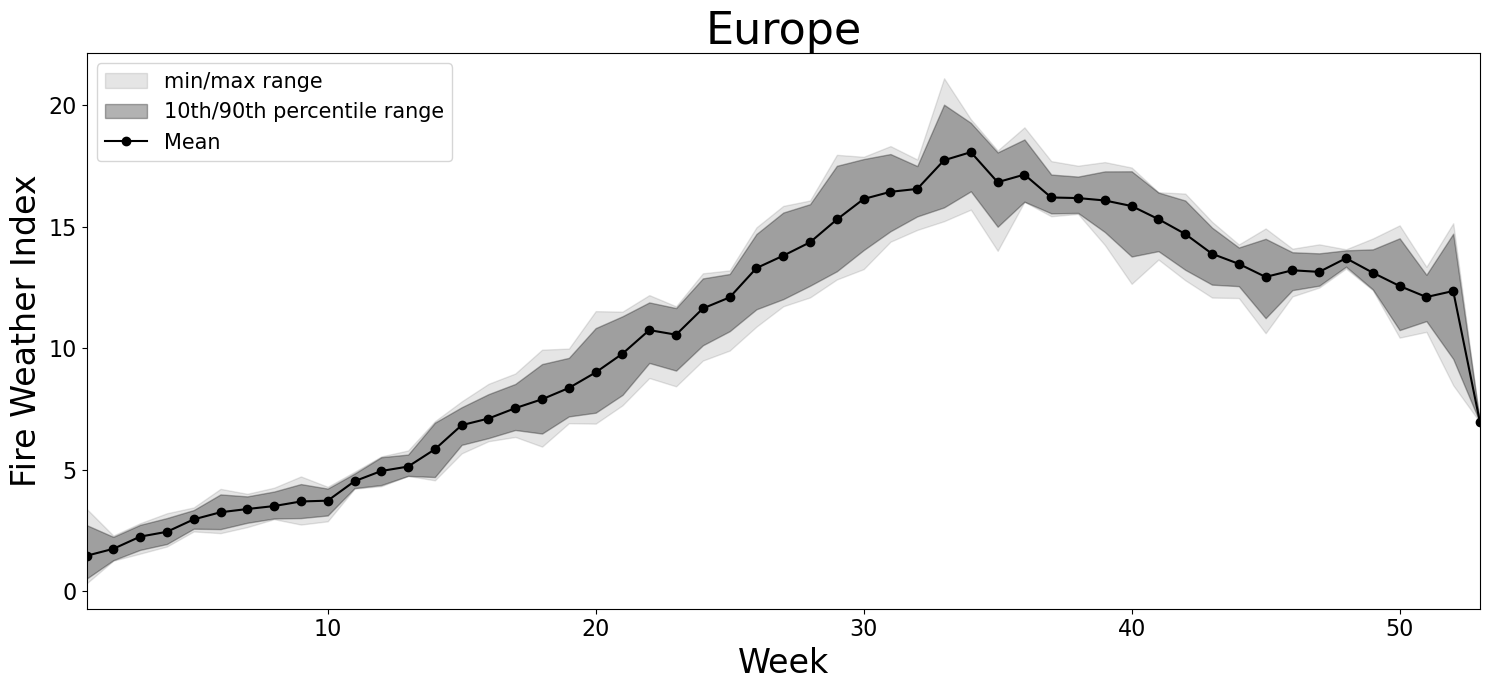

In [12]:
var1= seasonal_ave_masked.sel(time=slice('1991-01-01','2000-12-31')).mean(dim=['lon','lat'])
Tit1 = 'Europe'
fileout    = plot_dir + "Chan_Ann_prob_blizzard_days_CORDEX.png"
plot_seasonal_cycle(var1, Tit1,fileout)

#### FWI spl map Moderate category


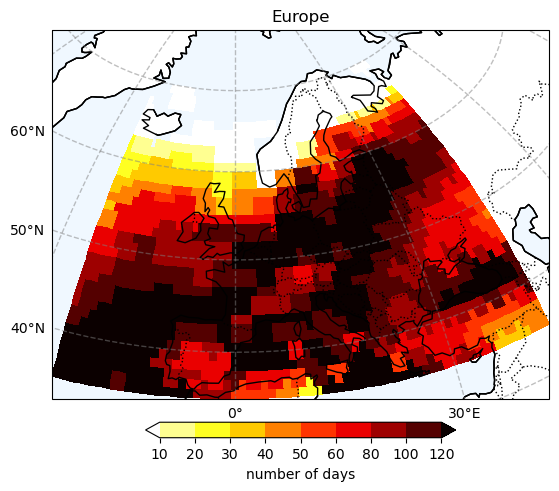

In [18]:
var1 = fwi_climatology_mod
V1_p_levels =[10, 20, 30, 40, 50, 60, 80 ,100, 120]
V1_cmap = 'hot'
Tit1 = 'Europe'
cblab = "number of days"
    
fileout    = plot_dir + "ClimateDT_FWI_Mod.png"
plot_spl_map(var1, V1_p_levels, V1_cmap, Tit1, cblab, fileout)

#### FWI spl map Very High category


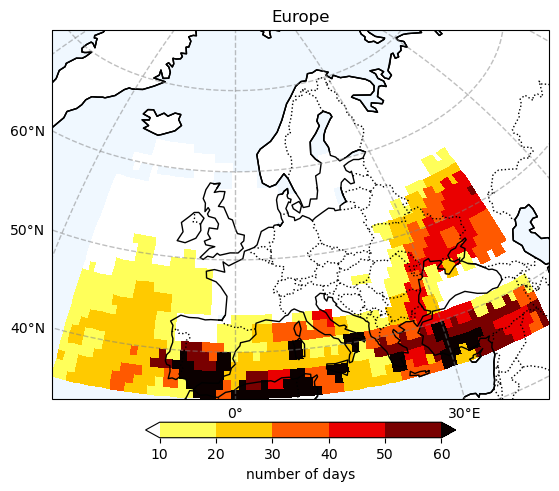

In [15]:
var1 = fwi_climatology_Vhigh
V1_p_levels = [10, 20, 30, 40, 50, 60]
V1_cmap = 'hot'
Tit1 = 'Europe'
cblab = "number of days"
fileout    = plot_dir + "ClimateDT_FWI_VHigh.png"
plot_spl_map(var1, V1_p_levels, V1_cmap, Tit1, cblab, fileout)


#### FWI spl map Extreme category


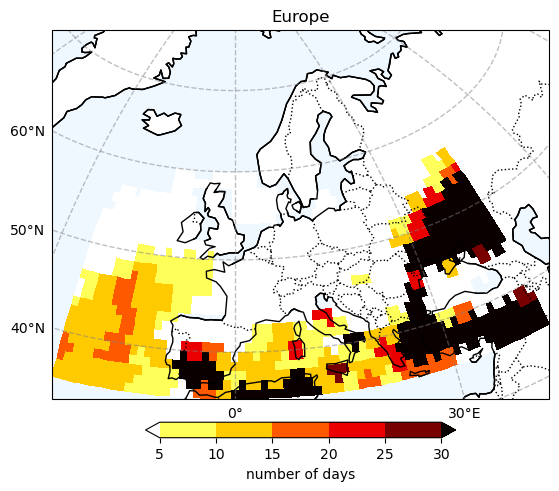

In [20]:
var1 = fwi_climatology_ext
V1_p_levels = [5, 10, 15, 20, 25, 30]
V1_cmap = 'hot'
Tit1 = 'Europe'
cblab = "number of days"
fileout    = plot_dir + "ClimateDT_FWI_Extreme.png"
plot_spl_map(var1, V1_p_levels, V1_cmap, Tit1, cblab, fileout)


#### FWI spl map FWI percentile-95


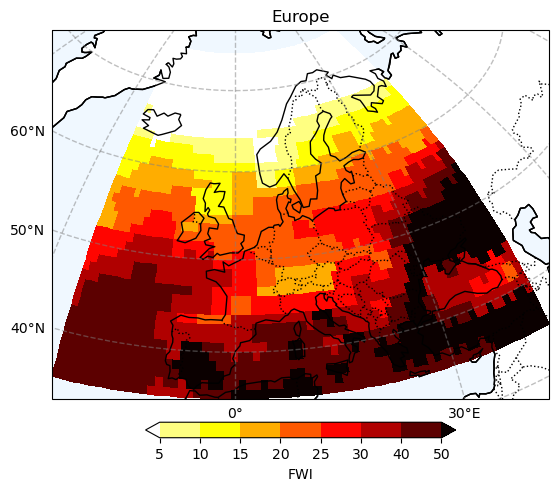

In [21]:
var1 = climatology_percentile_95.fwi
V1_p_levels = [5, 10, 15, 20, 25, 30, 40, 50]
V1_cmap = 'hot'
Tit1 = 'Europe'
cblab = "FWI"
fileout    = plot_dir + "ClimateDT_FWI_95per.png"
plot_spl_map(var1, V1_p_levels, V1_cmap, Tit1, cblab, fileout)


#### Plot Timeseries of Weekly FWI


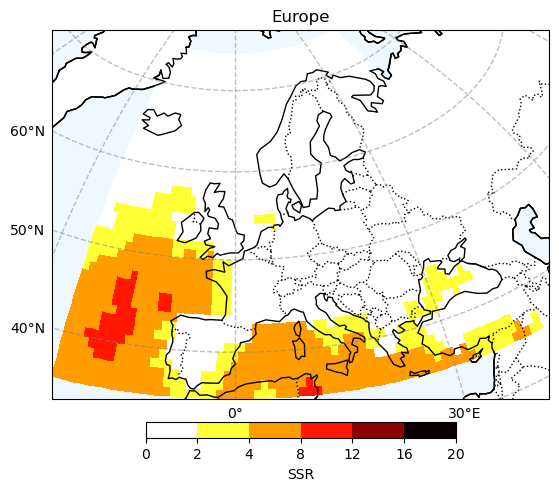

In [22]:
del(var1,V1_p_levels,V1_cmap,Tit1,fileout)
var1 = dsr_seasonal_climatology[0,:,:]
V1_p_levels = [0, 2, 4, 8, 12, 16, 20]
V1_cmap = 'hot'
Tit1 = 'Europe'
cblab = "SSR"
fileout    = plot_dir + "ClimateDT_DSR_DJF.png"
plot_spl_map(var1, V1_p_levels, V1_cmap, Tit1, cblab, fileout)



## Contributors
Suraj Polade, Finnish Meteorological Institute